# Random Forest

Random forests  good classification performance, scalability, and ease of use

The idea behind a random forest is to average multiple (deep) decision trees to build a more robust model that has a better generalization performance and is less susceptible to overfitting

## Steps to build Random Forest 

* Draw a random bootstrap sample of size n (randomly choose n samples from the training set with replacement)

* Grow a decision tree from the bootstrap sample. At each node:
    * Randomly select d features without replacement
    * Split the node using the feature that provides the best split according to the objective function, for instance, maximizing the information gain
    

* Repeat the steps 1-2 k times

* Aggregate the prediction by each tree to assign the class label by majority vote
    

Although random forests don't offer the same level of interpretability as decision trees, a big advantage of random forests is the higher amount of accuracy

In [1]:
## Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Load Data 

In [2]:
df=pd.read_csv('Fraud_Data.csv')

In [3]:
df.shape

(151112, 10)

In [4]:
df.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,class
0,22058,2/24/15 22:55,4/18/15 2:47,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,0
1,333320,6/7/15 20:39,6/8/15 1:38,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,0
2,1359,1/1/15 18:52,1/1/15 18:52,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 10 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
class             151112 non-null int64
dtypes: int64(4), object(6)
memory usage: 11.5+ MB


## EDA 

In [6]:
#confirm if we have multiple records for any user id
len(df.user_id.unique())

151112

In [7]:
#check for class skewness
df['class'].value_counts()

0    136961
1     14151
Name: class, dtype: int64

In [8]:
#groupby fraud class
df.groupby('class').mean()

,user_id,purchase_value,age
class,,,
0,200098.920123,36.929418,33.122356
1,200869.065366,36.993004,33.318281


People who doing fraudulent transcations seems to be on higher side in terms of age

In [9]:
#groupby browser used
df.groupby('browser').mean()

,user_id,purchase_value,age,class
browser,,,,
Chrome,200687.687248,37.031775,33.126921,0.098792
FireFox,200641.932466,36.846485,33.125640,0.095165
IE,199088.138890,36.815177,33.169467,0.086775
Opera,201405.358542,36.551959,32.679543,0.089227
Safari,199842.956460,37.020067,33.215957,0.090201


People who doing fraudulent transcations seems to be using chrome more often

In [10]:
#groupby sex variable
df.groupby('sex').mean()

,user_id,purchase_value,age,class
sex,,,,
F,200154.199764,36.892023,33.098887,0.091007
M,200183.023207,36.966215,33.170455,0.095523


### Data Preprocessing 

In [11]:
from datetime import datetime
#convert the date column from object to datetime stamp
# %y is required instead of %Y ( 2 digit year representation vs 4 digit year )
df['signup_time'] =  pd.to_datetime(df['signup_time'], format="%m/%d/%y %H:%M")

df['purchase_time'] =  pd.to_datetime(df['purchase_time'], format="%m/%d/%y %H:%M")


In [12]:
#validate the datatype for time columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 10 columns):
user_id           151112 non-null int64
signup_time       151112 non-null datetime64[ns]
purchase_time     151112 non-null datetime64[ns]
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
class             151112 non-null int64
dtypes: datetime64[ns](2), int64(4), object(4)
memory usage: 11.5+ MB


In [13]:
#validate the remaining columns
df.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'class'],
      dtype='object')

### Break Up Dates And Times Into Individual Features

In [14]:
# Create features for year, month, day, hour, and minute
df['signup_year'] = df['signup_time'].dt.year
df['signup_month'] = df['signup_time'].dt.month
df['signup_month'] = df['signup_time'].dt.dayofweek
df['signup_day'] = df['signup_time'].dt.day
df['signup_hour'] = df['signup_time'].dt.hour
df['signup_minute'] = df['signup_time'].dt.minute
df['purchase_year'] = df['purchase_time'].dt.year
df['purchase_month'] = df['purchase_time'].dt.month
df['purchase_month'] = df['purchase_time'].dt.dayofweek
df['purchase_day'] = df['purchase_time'].dt.day
df['purchase_hour'] = df['purchase_time'].dt.hour
df['purchase_minute'] = df['purchase_time'].dt.minute

In [15]:
## calculating time difference between sign up and purchase
df['date_difference']=(df['purchase_time']-df['signup_time']).dt.days

In [16]:
# removing user_id, signup_time,purchase_time columns
del df['user_id']
del df['device_id']
del df['signup_time']
del df['purchase_time']

In [17]:
df.columns

Index(['purchase_value', 'source', 'browser', 'sex', 'age', 'class',
       'signup_year', 'signup_month', 'signup_day', 'signup_hour',
       'signup_minute', 'purchase_year', 'purchase_month', 'purchase_day',
       'purchase_hour', 'purchase_minute', 'date_difference'],
      dtype='object')

In [18]:
df.head(3)

,purchase_value,source,browser,sex,age,class,signup_year,signup_month,signup_day,signup_hour,signup_minute,purchase_year,purchase_month,purchase_day,purchase_hour,purchase_minute,date_difference
0,34,SEO,Chrome,M,39,0,2015,1,24,22,55,2015,5,18,2,47,52
1,16,Ads,Chrome,F,53,0,2015,6,7,20,39,2015,0,8,1,38,0
2,15,SEO,Opera,M,53,1,2015,3,1,18,52,2015,3,1,18,52,0


### Dummification 

In [19]:
df_new=pd.get_dummies(df,columns=['source','browser','sex'])

In [20]:
df_new.columns

Index(['purchase_value', 'age', 'class', 'signup_year', 'signup_month',
       'signup_day', 'signup_hour', 'signup_minute', 'purchase_year',
       'purchase_month', 'purchase_day', 'purchase_hour', 'purchase_minute',
       'date_difference', 'source_Ads', 'source_Direct', 'source_SEO',
       'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera',
       'browser_Safari', 'sex_F', 'sex_M'],
      dtype='object')

In [21]:
df_new.shape

(151112, 24)

### Input/Output Data 

In [22]:
#import model specific libraries
from sklearn.model_selection import train_test_split

#create input dataset without including target variable( class column)
X=df_new.loc[:, df_new.columns != 'class']

In [23]:
#Validate the shape of input data X
X.shape

(151112, 23)

In [24]:
#Create the target data with only class column
y=df_new['class']
#Validate the shape of output data y
y.shape

(151112,)

#### Train Test split 

In [25]:
#Split the data into training and test data (70/30 ratio)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=100, stratify=y)

In [26]:
#validate the shape of train and test dataset
print (X_train.shape)
print (y_train.shape)

print (X_test.shape)
print (y_test.shape)

(105778, 23)
(105778,)
(45334, 23)
(45334,)


In [27]:
#check on number of positive classes in train and test data set
print(np.sum(y_train))
print(np.sum(y_test))

9906
4245


### Model Building & Training 

In [28]:
#import the randomforest classifier
from sklearn.ensemble import RandomForestClassifier

In [29]:
#Train the random forest classifier on training dataset
rf = RandomForestClassifier().fit(X_train,y_train)

In [30]:
# Model details and parameters
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
#validate the model performance on unseen data
rf.score(X_test, y_test)

0.95566241672916574

In [32]:
#make predictions on unseen data
predictions=rf.predict(X_test)

## Results 

In [33]:
#import confusion matrix , classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


### Confusion Matrix 

In [34]:
print(confusion_matrix(y_test, predictions))

[[41054    35]
 [ 1975  2270]]


### Classification Report 

In [35]:
print(classification_report(y_test, predictions,target_names=["Genuine", "Fraud"]))

             precision    recall  f1-score   support

    Genuine       0.95      1.00      0.98     41089
      Fraud       0.98      0.53      0.69      4245

avg / total       0.96      0.96      0.95     45334



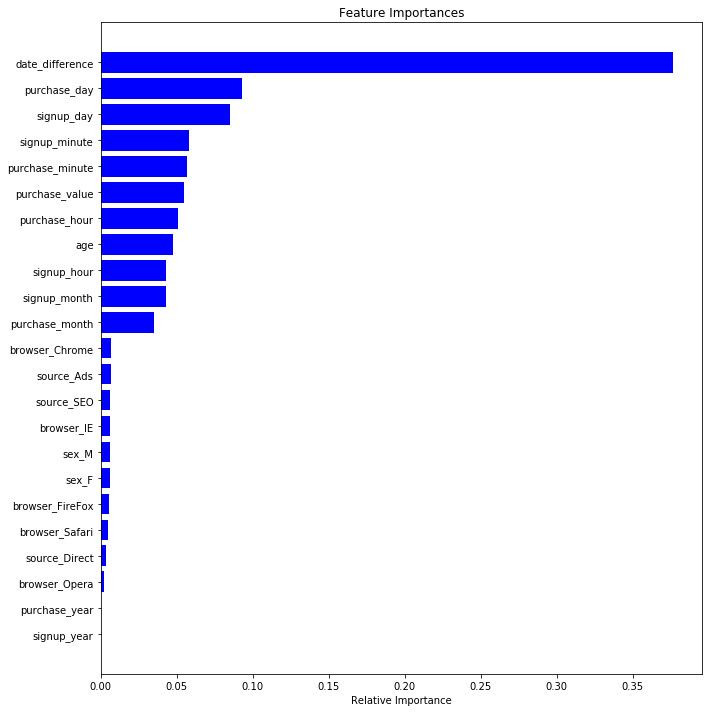

In [36]:
## Feature Importance 
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

## Hyperparameter Tunning

* rf.criterion: This is the criterion for how the splits are determined. The default is gini
* rf.bootstrap: A Boolean that indicates whether we used bootstrap samples when training random forest
* rf.n_jobs: The number of jobs to train and predict. If you want to use all the processors, set this to -1
* rf.max_features: This denotes the number of features to consider when making the best split
* rf.compute_importances: This helps us decide whether to compute the importance of the features
* rf.max_depth: This denotes how deep each tree can go

### Using GridSearchCV

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
#fit the model
rf_model=RandomForestClassifier()

In [46]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [40,50,60],
    'max_features': ['auto', 'sqrt', 'log2',.01, .5, .99],
    'n_estimators': [10,15,20,25,30]
}

In [47]:
#Run grid search algorithm
grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

This will try out  90 combinations of settings

In [48]:
#Fit the model on training data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] bootstrap=True, max_depth=40, max_features=auto, n_estimators=10 
[CV] bootstrap=True, max_depth=40, max_features=auto, n_estimators=10 
[CV] bootstrap=True, max_depth=40, max_features=auto, n_estimators=10 
[CV] bootstrap=True, max_depth=40, max_features=auto, n_estimators=15 
[CV]  bootstrap=True, max_depth=40, max_features=auto, n_estimators=10, total=   1.1s
[CV]  bootstrap=True, max_depth=40, max_features=auto, n_estimators=10, total=   1.1s
[CV] bootstrap=True, max_depth=40, max_features=auto, n_estimators=15 
[CV] bootstrap=True, max_depth=40, max_features=auto, n_estimators=15 
[CV]  bootstrap=True, max_depth=40, max_features=auto, n_estimators=10, total=   1.1s
[CV] bootstrap=True, max_depth=40, max_features=auto, n_estimators=20 
[CV]  bootstrap=True, max_depth=40, max_features=auto, n_estimators=15, total=   1.7s
[CV] bootstrap=True, max_depth=40, max_features=auto, n_estimators=20 
[CV]  bootstrap=True, max_

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.1s


[CV]  bootstrap=True, max_depth=40, max_features=log2, n_estimators=15, total=   1.7s
[CV] bootstrap=True, max_depth=40, max_features=log2, n_estimators=20 
[CV]  bootstrap=True, max_depth=40, max_features=log2, n_estimators=15, total=   1.8s
[CV]  bootstrap=True, max_depth=40, max_features=log2, n_estimators=15, total=   1.7s
[CV] bootstrap=True, max_depth=40, max_features=log2, n_estimators=20 
[CV] bootstrap=True, max_depth=40, max_features=log2, n_estimators=25 
[CV]  bootstrap=True, max_depth=40, max_features=log2, n_estimators=20, total=   2.2s
[CV] bootstrap=True, max_depth=40, max_features=log2, n_estimators=25 
[CV]  bootstrap=True, max_depth=40, max_features=log2, n_estimators=20, total=   2.2s
[CV] bootstrap=True, max_depth=40, max_features=log2, n_estimators=25 
[CV]  bootstrap=True, max_depth=40, max_features=log2, n_estimators=20, total=   2.2s
[CV] bootstrap=True, max_depth=40, max_features=log2, n_estimators=30 
[CV]  bootstrap=True, max_depth=40, max_features=log2, n_e

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min


[CV]  bootstrap=True, max_depth=50, max_features=0.5, n_estimators=15, total=   3.8s
[CV] bootstrap=True, max_depth=50, max_features=0.5, n_estimators=20 .
[CV]  bootstrap=True, max_depth=50, max_features=0.5, n_estimators=15, total=   3.9s
[CV] bootstrap=True, max_depth=50, max_features=0.5, n_estimators=25 .
[CV]  bootstrap=True, max_depth=50, max_features=0.5, n_estimators=20, total=   4.6s
[CV] bootstrap=True, max_depth=50, max_features=0.5, n_estimators=25 .
[CV]  bootstrap=True, max_depth=50, max_features=0.5, n_estimators=20, total=   4.7s
[CV] bootstrap=True, max_depth=50, max_features=0.5, n_estimators=25 .
[CV]  bootstrap=True, max_depth=50, max_features=0.5, n_estimators=20, total=   4.7s
[CV] bootstrap=True, max_depth=50, max_features=0.5, n_estimators=30 .
[CV]  bootstrap=True, max_depth=50, max_features=0.5, n_estimators=25, total=   6.1s
[CV] bootstrap=True, max_depth=50, max_features=0.5, n_estimators=30 .
[CV]  bootstrap=True, max_depth=50, max_features=0.5, n_estimato

[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  4.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [40, 50, 60], 'max_features': ['auto', 'sqrt', 'log2', 0.01, 0.5, 0.99], 'n_estimators': [10, 15, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [49]:
#validate the new score of model
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.96


In [50]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'bootstrap': True, 'max_depth': 40, 'max_features': 0.99, 'n_estimators': 20}
Best cross-validation score: 0.96


In [51]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features=0.99, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


### Re-training Model with best parameters

In [52]:
#Train the random forest classifier on training dataset
rf_tuned = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features=0.99, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False).fit(X_train,y_train)
#validate the model performance on unseen data
rf_tuned.score(X_test, y_test)
#make predictions on unseen data
tuned_predictions=rf_tuned.predict(X_test)

### Results on Tuned Model 

In [53]:
print(confusion_matrix(y_test, tuned_predictions))
print(classification_report(y_test, tuned_predictions,target_names=["Genuine", "Fraud"]))


[[41071    18]
 [ 1975  2270]]
             precision    recall  f1-score   support

    Genuine       0.95      1.00      0.98     41089
      Fraud       0.99      0.53      0.69      4245

avg / total       0.96      0.96      0.95     45334

